In [43]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
filepath = r'imu_logs\arc_fast.csv'
# Load your real data
df = pd.read_csv(filepath)

# Extract needed columns
t = df.index.values*0.01                    # Time in seconds
dt = np.diff(t, prepend=t[0])      # time steps (should be ~constant, but safe)


(188, 14)
Index(['timestamp', 'AccX', 'AccY', 'AccZ', 'AngX', 'AngY', 'AngZ', 'AsX',
       'AsY', 'AsZ', 'Q0', 'Q1', 'Q2', 'Q3'],
      dtype='object')


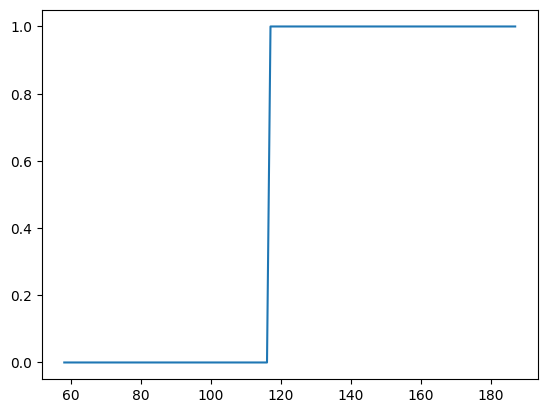

In [44]:

data = pd.read_csv(filepath)
#data.reset_index(inplace=True,drop=True)
#data.index = data.index*10/1000  #10
timestep = 1/100
print(data.shape)
print(data.columns)
data['total_acc_change']= (data[['AccX', 'AccY', 'AccZ']].diff().rolling(10).mean().sum(axis=1).abs())
data['active_period'] = (data['total_acc_change']>0.5).astype(int).rolling(10).min().rolling(50).max()#.shift(-20)
data['active_period'].plot()
#data = data[data['active_period']==1]
df = data

In [45]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

# ————— Extract raw accel and angles —————
acc = df[['AccX', 'AccY', 'AccZ']].values
rpy = df[['AngX', 'AngY', 'AngZ']].values

# ————— Build orientation objects —————
rot = R.from_euler('xyz', rpy, degrees=True)

# ————— Per-sample gravity removal & world-frame accel —————
g_world = np.array([0, 0, 9.81])
n = len(acc)
acc_world = np.zeros((n, 3))

for i in range(n):
    g_body_i     = rot[i].inv().apply(g_world)
    a_dyn_body   = acc[i] - g_body_i
    acc_world[i] = rot[i].apply(a_dyn_body)

# ————— Remove mean residual to zero net accel —————
residual_mean = np.mean(acc_world, axis=0)
acc_world -= residual_mean

# ————— Compute acceleration magnitude —————
a_mag = np.linalg.norm(acc_world, axis=1)

# ————— Manual trapezoidal integration at 100 Hz with deadband —————
dt = 1.0 / 100.0  # 0.01 seconds
vel = np.zeros_like(acc_world)
pos = np.zeros_like(acc_world)

deadband = 9  # m/s²

for i in range(1, n):
    # integrate normally
    vel[i] = vel[i-1] + 0.5 * (acc_world[i] + acc_world[i-1]) * dt
    pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt

    # if within deadband, force at-rest
    if a_mag[i] < deadband:
        vel[i] = 0
        pos[i] = pos[i-1]

# ————— Plot trajectory with |a| in hover —————
fig = go.Figure([
    go.Scatter3d(
        x=pos[:, 0], y=pos[:, 1], z=pos[:, 2],
        mode='lines',
        line=dict(color='blue', width=4),
        name='Trajectory',
        customdata=a_mag[:, None],
        hovertemplate=(
            'X: %{x:.3f} m<br>'
            'Y: %{y:.3f} m<br>'
            'Z: %{z:.3f} m<br>'
            '|a|: %{customdata[0]:.3f} m/s²'
        )
    ),
    go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers',
        marker=dict(color='green', size=8),
        name='Start',
        hovertemplate='Start<br>X: 0<br>Y: 0<br>Z: 0'
    ),
    go.Scatter3d(
        x=[pos[-1, 0]], y=[pos[-1, 1]], z=[pos[-1, 2]],
        mode='markers',
        marker=dict(color='red', size=8),
        name='End',
        hovertemplate=(
            'End<br>'
            'X: %{x:.3f} m<br>'
            'Y: %{y:.3f} m<br>'
            'Z: %{z:.3f} m'
        )
    )
])
fig.update_layout(
    scene=dict(
        xaxis_title='X [m]',
        yaxis_title='Y [m]',
        zaxis_title='Z [m]',
        aspectmode='data'
    ),
    title='Trajectory with Deadband Rest-Clamp & |a| in Hover',
    margin=dict(l=0, r=0, b=0, t=30)
)
fig.show()


In [53]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

def compute_trajectory(df, deadband=0.1, sample_rate=100):
    """
    Computes world-frame trajectory, velocity, and acceleration magnitude 
    from raw IMU DataFrame.
    
    Parameters:
    - df: DataFrame with columns ['AccX','AccY','AccZ','AngX','AngY','AngZ']
    - deadband: threshold for |a| below which the device is considered at rest
    - sample_rate: sampling frequency in Hz
    
    Returns:
    - pos: (N,3) array of positions [m]
    - vel: (N,3) array of velocities [m/s]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    """
    # Extract raw accel and angles
    acc = df[['AccX', 'AccY', 'AccZ']].values
    rpy = df[['AngX', 'AngY', 'AngZ']].values
    n = len(acc)
    
    # Build orientation objects
    rot = R.from_euler('xyz', rpy, degrees=True)
    
    # Per-sample gravity removal & world-frame accel
    g_world = np.array([0, 0, 9.81])
    acc_world = np.zeros((n, 3))
    for i in range(n):
        g_body_i     = rot[i].inv().apply(g_world)
        a_dyn_body   = acc[i] - g_body_i
        acc_world[i] = rot[i].apply(a_dyn_body)
    
    # Remove mean residual to zero net accel
    residual_mean = np.mean(acc_world, axis=0)
    acc_world -= residual_mean
    
    # Compute acceleration magnitude
    a_mag = np.linalg.norm(acc_world, axis=1)
    
    # Manual trapezoidal integration with deadband
    dt = 1.0 / sample_rate
    vel = np.zeros_like(acc_world)
    pos = np.zeros_like(acc_world)
    
    for i in range(1, n):
        # Integrate
        vel[i] = vel[i-1] + 0.5 * (acc_world[i] + acc_world[i-1]) * dt
        pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt
        
        # Deadband rest clamp
        if a_mag[i] < deadband:
            vel[i] = 0
            pos[i] = pos[i-1]
    
    return pos, vel, a_mag

def plot_trajectory(pos, a_mag, title='Trajectory with Deadband & |a| in Hover'):
    """
    Plots a 3D trajectory with acceleration magnitude in hover info.
    
    Parameters:
    - pos: (N,3) array of positions [m]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    - title: Figure title string
    """
    fig = go.Figure([
        go.Scatter3d(
            x=pos[:,0], y=pos[:,1], z=pos[:,2],
            mode='lines+markers',
            line=dict(color='blue', width=2),
            marker=dict(color='blue', size=2),
            name='Trajectory',
            customdata=a_mag[:, None],
            hovertemplate=(
                'X: %{x:.3f} m<br>'
                'Y: %{y:.3f} m<br>'
                'Z: %{z:.3f} m<br>'
                '|a|: %{customdata[0]:.3f} m/s²'
            )
        ),
        go.Scatter3d(
            x=[0], y=[0], z=[0],
            mode='markers',
            marker=dict(color='green', size=8),
            name='Start',
            hovertemplate='Start<br>X: 0<br>Y: 0<br>Z: 0'
        ),
        go.Scatter3d(
            x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
            mode='markers',
            marker=dict(color='red', size=8),
            name='End',
            hovertemplate=(
                'End<br>'
                'X: %{x:.3f} m<br>'
                'Y: %{y:.3f} m<br>'
                'Z: %{z:.3f} m'
            )
        )
    ])
    fig.update_layout(
        scene=dict(
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            aspectmode='data'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# Example usage:
# df = pd.read_csv('your_data.csv')
# pos, vel, a_mag = compute_trajectory(df, deadband=0.1, sample_rate=100)
# plot_trajectory(pos, a_mag)


In [57]:
pos, vel, a_mag = compute_trajectory(df, deadband=6, sample_rate=100)
plot_trajectory(pos, a_mag)


In [48]:
def plot_trajectory_with_dots(pos, a_mag, title='Trajectory with Dots & |a| in Hover'):
    """
    Plots a 3D trajectory with small marker dots at every data point,
    and acceleration magnitude in hover info.
    
    Parameters:
    - pos: (N,3) array of positions [m]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    - title: Figure title
    """
    fig = go.Figure([
        go.Scatter3d(
            x=pos[:,0], y=pos[:,1], z=pos[:,2],
            mode='lines+markers',
            line=dict(color='blue', width=2),
            marker=dict(color='blue', size=2),
            name='Trajectory',
            customdata=a_mag[:, None],
            hovertemplate=(
                'X: %{x:.3f} m<br>'
                'Y: %{y:.3f} m<br>'
                'Z: %{z:.3f} m<br>'
                '|a|: %{customdata[0]:.3f} m/s²'
            )
        ),
        go.Scatter3d(
            x=[pos[0,0]], y=[pos[0,1]], z=[pos[0,2]],
            mode='markers',
            marker=dict(color='green', size=6),
            name='Start',
            hovertemplate='Start<br>X: %{x:.3f} m<br>Y: %{y:.3f} m<br>Z: %{z:.3f} m'
        ),
        go.Scatter3d(
            x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
            mode='markers',
            marker=dict(color='red', size=6),
            name='End',
            hovertemplate='End<br>X: %{x:.3f} m<br>Y: %{y:.3f} m<br>Z: %{z:.3f} m'
        )
    ])
    fig.update_layout(
        scene=dict(
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            aspectmode='data'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

In [ ]:
plot_trajectory_with_dots(pos, a_mag,)
